In [49]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from tqdm import tqdm
import os
from datetime import datetime
import random


In [51]:
class ReLU:
    def forward(self, x):
        self.x = x
        return np.maximum(0, x)
    
    def backward(self, grad):
        return grad * (self.x > 0)

class Tanh:
    def forward(self, x):
        self.output = np.tanh(x)
        return self.output
    
    def backward(self, grad):
        return grad * (1 - self.output ** 2)

class Sigmoid:
    def forward(self, x):
        self.output = 1 / (1 + np.exp(-np.clip(x, -500, 500)))
        return self.output
    
    def backward(self, grad):
        return grad * self.output * (1 - self.output)

class Identity:
    def forward(self, x):
        return x
    
    def backward(self, grad):
        return grad

In [52]:
class Linear:
    def __init__(self, input_dim, output_dim, activation):
        self.weights = np.random.randn(input_dim, output_dim) * np.sqrt(2.0 / input_dim)
        self.biases = np.zeros(output_dim)
        self.activation = activation
        self.grad_weights = np.zeros_like(self.weights)
        self.grad_biases = np.zeros_like(self.biases)
    
    def forward(self, x):
        self.input = x
        self.z = x @ self.weights + self.biases
        self.output = self.activation.forward(self.z)
        return self.output
    
    def backward(self, grad):
        grad = self.activation.backward(grad)
        self.grad_weights += self.input.T @ grad
        self.grad_biases += np.sum(grad, axis=0)
        return grad @ self.weights.T


In [53]:
class Model:
    def __init__(self, layers, loss_type='mse'):
        self.layers = layers
        self.loss_type = loss_type
    
    def forward(self, x):
        for layer in self.layers:
            x = layer.forward(x)
        return x
    
    def backward(self, grad):
        for layer in reversed(self.layers):
            grad = layer.backward(grad)
    
    def mse_loss(self, y_pred, y_true):
        return np.mean((y_pred - y_true) ** 2)
    
    def mse_loss_grad(self, y_pred, y_true):
        return 2 * (y_pred - y_true) / y_true.shape[0]
    
    def bce_loss(self, y_pred, y_true):
        y_pred = np.clip(y_pred, 1e-7, 1 - 1e-7)
        return -np.mean(y_true * np.log(y_pred) + (1 - y_true) * np.log(1 - y_pred))
    
    def bce_loss_grad(self, y_pred, y_true):
        y_pred = np.clip(y_pred, 1e-7, 1 - 1e-7)
        return (-(y_true / y_pred) + (1 - y_true) / (1 - y_pred)) / y_true.shape[0]
    
    def train(self, x, y):
        y_pred = self.forward(x)
        
        if self.loss_type == 'mse':
            loss = self.mse_loss(y_pred, y)
            grad = self.mse_loss_grad(y_pred, y)
        else:
            loss = self.bce_loss(y_pred, y)
            grad = self.bce_loss_grad(y_pred, y)
        
        self.backward(grad)
        return loss
    
    def zero_grad(self):
        for layer in self.layers:
            layer.grad_weights.fill(0)
            layer.grad_biases.fill(0)
    
    def update(self, lr=0.01):
        for layer in self.layers:
            layer.weights -= lr * layer.grad_weights
            layer.biases -= lr * layer.grad_biases
        self.zero_grad()
    
    def predict(self, x):
        return self.forward(x)
    
    def save_to(self, path):
        data = {}
        for i, layer in enumerate(self.layers):
            data[f'layer_{i}_weights'] = layer.weights
            data[f'layer_{i}_biases'] = layer.biases
        np.savez(path, **data)
    
    def load_from(self, path):
        data = np.load(path)
        for i, layer in enumerate(self.layers):
            weights_key = f'layer_{i}_weights'
            biases_key = f'layer_{i}_biases'
            
            if weights_key not in data or biases_key not in data:
                raise ValueError(f"Missing layer {i} in saved file")
            
            if data[weights_key].shape != layer.weights.shape:
                raise ValueError(f"Weight shape mismatch for layer {i}")
            
            if data[biases_key].shape != layer.biases.shape:
                raise ValueError(f"Bias shape mismatch for layer {i}")
            
            layer.weights = data[weights_key]
            layer.biases = data[biases_key]

In [74]:
def train_model(model, dataset, batch_size=32, grad_accum_steps=1, lr=0.01, 
                max_epochs=200, patience=30, rel_threshold=0.001): #for best acc use pat = 100, rel_thres = 0.0001
    losses = []
    samples_seen = []
    total_samples = 0
    epoch_losses = []
    
    for epoch in tqdm(range(max_epochs), desc="Training"):
        coords, labels = dataset.get_shuffled()
        epoch_loss = 0
        n_batches = 0
        
        for i in range(0, len(coords), batch_size):
            batch_x = coords[i:i+batch_size]
            batch_y = labels[i:i+batch_size].reshape(-1, 1)
            
            loss = model.train(batch_x, batch_y)
            epoch_loss += loss
            n_batches += 1
            total_samples += len(batch_x)
            
            if (n_batches % grad_accum_steps) == 0:
                model.update(lr)
            
            losses.append(loss)
            samples_seen.append(total_samples)
        
        avg_epoch_loss = epoch_loss / n_batches
        epoch_losses.append(avg_epoch_loss)
        
        if epoch >= patience:
            if epoch_losses[-1] >= (1-rel_threshold) * epoch_losses[-patience-1]:
                print(f"Early stopping at epoch {epoch}")
                break
    
    return losses, samples_seen, epoch_losses


In [55]:
def compute_numerical_gradient(model, x, y, epsilon=1e-5):
    numerical_grads = []
    
    for layer in model.layers:
        layer_weight_grads = np.zeros_like(layer.weights)
        
        for i in range(layer.weights.shape[0]):
            for j in range(layer.weights.shape[1]):
                layer.weights[i, j] += epsilon
                y_pred = model.forward(x)
                loss_plus = model.mse_loss(y_pred, y) if model.loss_type == 'mse' else model.bce_loss(y_pred, y)
                
                layer.weights[i, j] -= 2 * epsilon
                y_pred = model.forward(x)
                loss_minus = model.mse_loss(y_pred, y) if model.loss_type == 'mse' else model.bce_loss(y_pred, y)
                
                layer.weights[i, j] += epsilon
                
                layer_weight_grads[i, j] = (loss_plus - loss_minus) / (2 * epsilon)
        
        numerical_grads.append(layer_weight_grads)
    
    return numerical_grads

In [56]:
def verify_gradients(model, dataset):
    coords, labels = dataset.get_shuffled()
    x = coords[:4]
    y = labels[:4].reshape(-1, 1)
    
    model.zero_grad()
    model.train(x, y)
    
    numerical_grads = compute_numerical_gradient(model, x, y)
    
    print("\nGradient Verification:")
    for i, (layer, num_grad) in enumerate(zip(model.layers, numerical_grads)):
        diff = np.abs(layer.grad_weights - num_grad)
        max_diff = np.max(diff)
        mean_diff = np.mean(diff)
        print(f"Layer {i}: Max diff = {max_diff:.6f}, Mean diff = {mean_diff:.6f}")

In [8]:
class XORDataset:
    def __init__(self):
        self.coords = np.array([[0, 0], [0, 1], [1, 0], [1, 1]], dtype=float)
        self.labels = np.array([0, 1, 1, 0])
    
    def get_shuffled(self):
        indices = np.random.permutation(len(self.coords))
        return self.coords[indices], self.labels[indices]

In [64]:
print("Testing XOR with Multiple Architectures")

dataset = XORDataset()
coords, labels = dataset.get_shuffled()

architectures = [
    # (layer_widths, activation_names)
    ([(4, 'relu'), (8, 'sigmoid'), (1, 'tanh')], "relu_1layer"),
    ([(8, 'relu'), (8, 'tanh'), (1, 'tanh')], "relu_tanh_2layer"),
    ([(8, 'tanh'), (8, 'sigmoid'), (1, 'sigmoid')], "tanh_sigmoid_2layer"),
    ([(8, 'relu'), (8, 'relu'), (8, 'tanh'), (1, 'sigmoid')], "relu_relu_tanh_3layer"),
    ([(16, 'relu'), (8, 'tanh'), (4, 'sigmoid'), (1, 'identity')], "mixed_3layer"),
]

activation_map = {
    'relu': ReLU,
    'tanh': Tanh,
    'sigmoid': Sigmoid,
    'identity': Identity
}

results = []

for arch, arch_name in architectures:
    layers = []
    input_dim = 2
    for width, act_name in arch:
        act_class = activation_map[act_name]
        layers.append(Linear(input_dim, width, act_class()))
        input_dim = width
    model = Model(layers, 'mse')
    losses, samples, _ = train_model(model, dataset, batch_size=4, grad_accum_steps=1, 
                                     lr=0.05, max_epochs=1000)
    predictions = model.predict(coords)
    predicted_labels = (predictions > 0.5).astype(int).flatten()
    accuracy = np.mean(predicted_labels == labels)
    print(f"{arch_name}: Accuracy={accuracy*100:.2f}%")
    results.append((arch_name, accuracy))




Testing XOR with Multiple Architectures


Training:   0%|          | 0/1000 [00:00<?, ?it/s]

Training: 100%|██████████| 1000/1000 [00:00<00:00, 8038.22it/s]


relu_1layer: Accuracy=100.00%


Training: 100%|██████████| 1000/1000 [00:00<00:00, 13385.36it/s]


relu_tanh_2layer: Accuracy=100.00%


Training: 100%|██████████| 1000/1000 [00:00<00:00, 10862.22it/s]


tanh_sigmoid_2layer: Accuracy=75.00%


Training: 100%|██████████| 1000/1000 [00:00<00:00, 7822.19it/s]


relu_relu_tanh_3layer: Accuracy=100.00%


Training: 100%|██████████| 1000/1000 [00:00<00:00, 9626.92it/s]

mixed_3layer: Accuracy=100.00%


In [67]:
print("Testing XOR with Multiple Architectures")

dataset = XORDataset()
coords, labels = dataset.get_shuffled()

architectures = [
    ([(8, 'relu'), (1, 'sigmoid')], "arc_1"),
    ([(16, 'tanh'), (8, 'relu'), (1, 'identity')], "arc_2"),
    ([(32, 'sigmoid'), (16, 'tanh'), (8, 'relu'), (1, 'sigmoid')], "arc_3"),
    ([(64, 'relu'), (32, 'sigmoid'), (16, 'tanh'), (8, 'identity'), (1, 'tanh')], "arc_4"),
    ([(48, 'tanh'), (32, 'identity'), (16, 'relu'), (8, 'sigmoid'), (1, 'identity')], "arc_5"),
]


activation_map = {
    'relu': ReLU,
    'tanh': Tanh,
    'sigmoid': Sigmoid,
    'identity': Identity
}

results = []

for arch, arch_name in architectures:
    print(f"\n{'='*40}\nArchitecture: {arch_name}")
    layers = []
    input_dim = 2
    for width, act_name in arch:
        act_class = activation_map[act_name]
        layers.append(Linear(input_dim, width, act_class()))
        input_dim = width

    model = Model(layers, 'mse')

    verify_gradients(model, dataset)

    # Train model on XOR
    losses, samples, _ = train_model(model, dataset, batch_size=4, grad_accum_steps=1, 
                                     lr=0.1, max_epochs=500)

    # Evaluate accuracy
    predictions = model.predict(coords)
    predicted_labels = (predictions > 0.5).astype(int).flatten()
    accuracy = np.mean(predicted_labels == labels)
    print(f"{arch_name}: Accuracy = {accuracy*100:.2f}%")
    results.append((arch_name, accuracy))

Testing XOR with Multiple Architectures

Architecture: arc_1

Gradient Verification:
Layer 0: Max diff = 0.000000, Mean diff = 0.000000
Layer 1: Max diff = 0.000000, Mean diff = 0.000000


Training: 100%|██████████| 500/500 [00:00<00:00, 7573.63it/s]


arc_1: Accuracy = 100.00%

Architecture: arc_2

Gradient Verification:
Layer 0: Max diff = 0.000000, Mean diff = 0.000000
Layer 1: Max diff = 0.000000, Mean diff = 0.000000
Layer 2: Max diff = 0.000000, Mean diff = 0.000000


Training: 100%|██████████| 500/500 [00:00<00:00, 10540.73it/s]


arc_2: Accuracy = 100.00%

Architecture: arc_3

Gradient Verification:
Layer 0: Max diff = 0.000000, Mean diff = 0.000000
Layer 1: Max diff = 0.000000, Mean diff = 0.000000
Layer 2: Max diff = 0.000000, Mean diff = 0.000000
Layer 3: Max diff = 0.000000, Mean diff = 0.000000


Training: 100%|██████████| 500/500 [00:00<00:00, 8396.27it/s]


arc_3: Accuracy = 100.00%

Architecture: arc_4

Gradient Verification:
Layer 0: Max diff = 0.000000, Mean diff = 0.000000
Layer 1: Max diff = 0.000000, Mean diff = 0.000000
Layer 2: Max diff = 0.000000, Mean diff = 0.000000
Layer 3: Max diff = 0.000000, Mean diff = 0.000000
Layer 4: Max diff = 0.000000, Mean diff = 0.000000


Training: 100%|██████████| 500/500 [00:00<00:00, 6594.90it/s]

arc_4: Accuracy = 100.00%

Architecture: arc_5



Gradient Verification:
Layer 0: Max diff = 0.000000, Mean diff = 0.000000
Layer 1: Max diff = 0.000000, Mean diff = 0.000000
Layer 2: Max diff = 0.000000, Mean diff = 0.000000
Layer 3: Max diff = 0.000000, Mean diff = 0.000000
Layer 4: Max diff = 0.000000, Mean diff = 0.000000


Training: 100%|██████████| 500/500 [00:00<00:00, 5801.09it/s]

arc_5: Accuracy = 100.00%


In [29]:
class BorderDataset:
    def __init__(self, image_path):
        img = Image.open(image_path).convert('RGB')
        img_array = np.array(img)
        
        orange_mask = (img_array[:, :, 0] > 200) & (img_array[:, :, 1] > 100) & (img_array[:, :, 2] < 100)
        purple_mask = (img_array[:, :, 0] > 100) & (img_array[:, :, 1] < 100) & (img_array[:, :, 2] > 150)
        
        self.labels = orange_mask.astype(int)
        self.height, self.width = self.labels.shape
        
        coords = []
        labels = []
        for y in range(self.height):
            for x in range(self.width):
                coords.append([x / (self.width - 1), y / (self.height - 1)])
                labels.append(self.labels[y, x])
        
        self.coords = np.array(coords)
        self.labels_flat = np.array(labels)
    
    def get_shuffled(self):
        indices = np.random.permutation(len(self.coords))
        return self.coords[indices], self.labels_flat[indices]

In [30]:
def train_and_evaluate_map(image_path, architecture, batch_size=32, grad_accum=1, 
                          lr=0.01, run_name=None, seed=21, save = True):
    
    random.seed(seed)
    np.random.seed(seed)
    
    if run_name is None:
        run_name = datetime.now().strftime("%Y%m%d_%H%M%S")
    
    if save:
        run_dir = f"runs/{run_name}"
        os.makedirs(run_dir, exist_ok=True)
    
    dataset = BorderDataset(image_path)
    
    layers = []
    input_dim = 2
    for width, activation_name in architecture:
        if activation_name == 'relu':
            act = ReLU()
        elif activation_name == 'tanh':
            act = Tanh()
        elif activation_name == 'sigmoid':
            act = Sigmoid()
        else:
            act = Identity()
        
        layers.append(Linear(input_dim, width, act))
        input_dim = width
    
    model = Model(layers, 'bce')
    
    losses, samples_seen, epoch_losses = train_model(
        model, dataset, batch_size, grad_accum, lr, max_epochs=1000
    )
    
    if save:
        plt.figure(figsize=(10, 6))
        plt.plot(samples_seen, losses)
        plt.xlabel('Samples Seen')
        plt.ylabel('Loss')
        plt.title('Training Loss vs Samples')
        plt.grid(True)
        plt.savefig(f"{run_dir}/loss_curve.png")
        plt.close()
    
    all_coords = []
    all_labels = []
    for y in range(dataset.height):
        for x in range(dataset.width):
            all_coords.append([x / (dataset.width - 1), y / (dataset.height - 1)])
            all_labels.append(dataset.labels[y, x])
    
    all_coords = np.array(all_coords)
    all_labels = np.array(all_labels)
    
    predictions = model.predict(all_coords)
    predicted_labels = (predictions > 0.5).astype(int).flatten()
    
    pred_map = predicted_labels.reshape(dataset.height, dataset.width)
    error_map = (predicted_labels != all_labels).reshape(dataset.height, dataset.width)
    
    accuracy = np.mean(predicted_labels == all_labels)
    final_loss = epoch_losses[-1]

    if save:
    
        fig, axes = plt.subplots(1, 3, figsize=(15, 5))
        
        axes[0].imshow(dataset.labels, cmap='RdYlBu')
        axes[0].set_title('Ground Truth')
        axes[0].axis('off')
        
        axes[1].imshow(pred_map, cmap='RdYlBu')
        axes[1].set_title(f'Prediction (Acc: {accuracy*100:.2f}%)')
        axes[1].axis('off')
        
        axes[2].imshow(dataset.labels, cmap='gray', alpha=0.5)
        axes[2].imshow(error_map, cmap='Reds', alpha=0.5)
        axes[2].set_title('Error Map')
        axes[2].axis('off')
        
        plt.tight_layout()
        plt.savefig(f"{run_dir}/results.png")
        plt.close()
        
        model.save_to(f"{run_dir}/model.npz")
        
        with open(f"{run_dir}/config.txt", 'w') as f:
            f.write(f"Architecture: {architecture}\n")
            f.write(f"Batch Size: {batch_size}\n")
            f.write(f"Grad Accumulation: {grad_accum}\n")
            f.write(f"Learning Rate: {lr}\n")
            f.write(f"Final Loss: {final_loss:.6f}\n")
            f.write(f"Accuracy: {accuracy*100:.2f}%\n")
        
        print(f"Run {run_name}: Loss={final_loss:.6f}, Accuracy={accuracy*100:.2f}%\n")
    
    return final_loss, accuracy

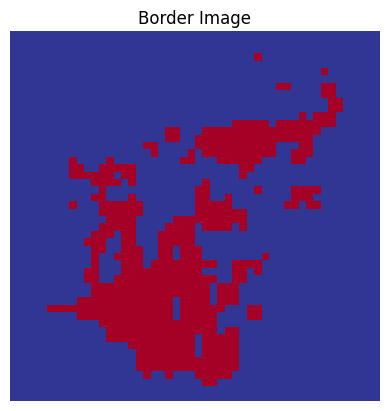

[[0.85714286 0.55102041]
 [0.40816327 0.2244898 ]
 [0.08163265 0.7755102 ]
 ...
 [0.69387755 0.30612245]
 [0.34693878 0.24489796]
 [0.36734694 0.73469388]]
[1 1 1 ... 0 1 0]


In [31]:
#Image 
image = "Q1-20251007T170148Z-1-001/Q1/border.png"

dataset = BorderDataset(image)
plt.imshow(dataset.labels, cmap='RdYlBu')
plt.title('Border Image')
plt.axis('off')
plt.show()

coords, labels = dataset.get_shuffled()
print(coords)
print(labels)


Training:   4%|▍         | 44/1000 [00:00<00:09, 104.55it/s]


Early stopping at epoch 44


Training:  17%|█▋        | 166/1000 [00:02<00:12, 68.12it/s]


Early stopping at epoch 166


Training:  17%|█▋        | 166/1000 [00:02<00:14, 59.02it/s]


Early stopping at epoch 166


Training:  11%|█         | 111/1000 [00:03<00:26, 33.51it/s]


Early stopping at epoch 111


Training:  10%|▉         | 98/1000 [00:01<00:16, 53.22it/s]


Early stopping at epoch 98


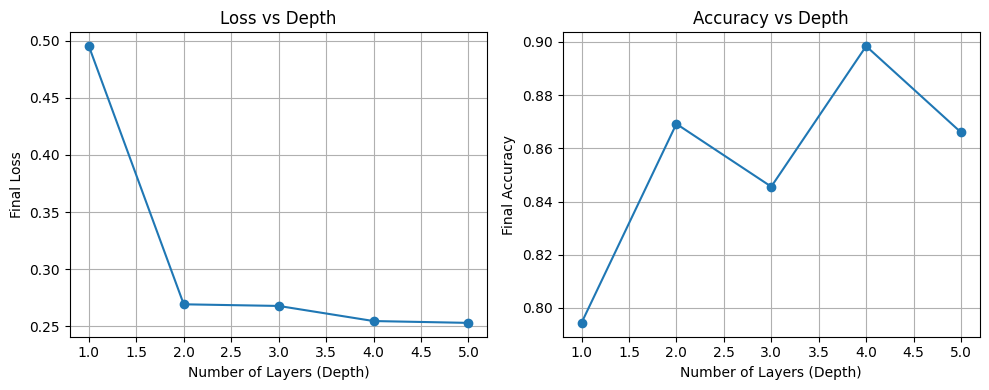

Training:   8%|▊         | 76/1000 [00:01<00:15, 61.04it/s]


Early stopping at epoch 76


Training:   9%|▉         | 89/1000 [00:01<00:14, 61.15it/s]


Early stopping at epoch 89


Training:  17%|█▋        | 166/1000 [00:03<00:15, 52.60it/s]


Early stopping at epoch 166


Training:  11%|█         | 111/1000 [00:01<00:15, 58.60it/s]


Early stopping at epoch 111


Training:  12%|█▏        | 122/1000 [00:02<00:18, 47.33it/s]


Early stopping at epoch 122


Training:  16%|█▋        | 163/1000 [00:04<00:25, 32.94it/s]


Early stopping at epoch 163


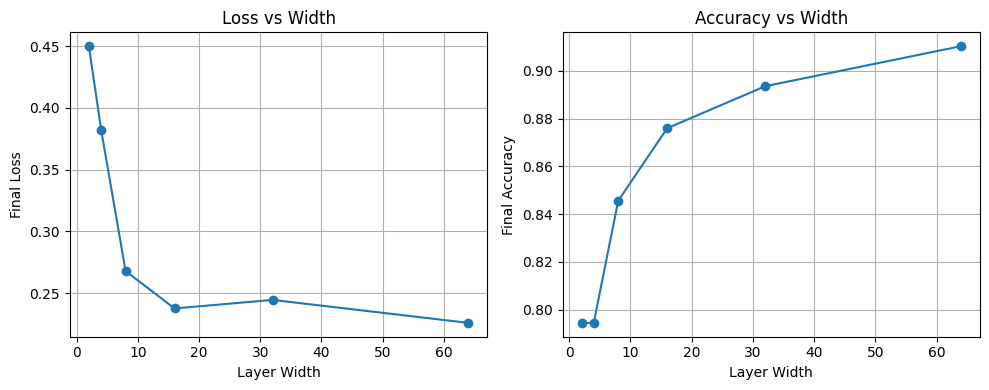

In [15]:
import matplotlib.pyplot as plt

image = "Q1-20251007T170148Z-1-001/Q1/border.png"
seed = 21
random.seed(seed)
np.random.seed(seed)

# Vary depth (number of layers), fixed width
fixed_width = 8
max_layers = 5
depths = list(range(1, max_layers + 1))
losses_depth = []
accs_depth = []

for depth in depths:
    arch = [(fixed_width, 'relu')] * depth + [(1, 'sigmoid')]
    run_name = f"depth_{depth}_width_{fixed_width}"
    final_loss, accuracy = train_and_evaluate_map(image, arch, batch_size=16, grad_accum=1, lr=0.03, run_name=run_name, seed=seed, save=False)
    losses_depth.append(final_loss)
    accs_depth.append(accuracy)

plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(depths, losses_depth, marker='o')
plt.xlabel("Number of Layers (Depth)")
plt.ylabel("Final Loss")
plt.title("Loss vs Depth")
plt.grid(True)

plt.subplot(1,2,2)
plt.plot(depths, accs_depth, marker='o')
plt.xlabel("Number of Layers (Depth)")
plt.ylabel("Final Accuracy")
plt.title("Accuracy vs Depth")
plt.grid(True)
plt.tight_layout()
plt.show()

# For a Fixed number of layers, vary the width of the layers. Plot the final loss and accuracy as a function of width.
fixed_layers = 3
widths = [2, 4, 8, 16, 32, 64]
losses_width = []
accs_width = []

for width in widths:
    arch = [(width, 'relu')] * fixed_layers + [(1, 'sigmoid')]
    run_name = f"layers_{fixed_layers}_width_{width}"
    final_loss, accuracy = train_and_evaluate_map(image, arch, batch_size=16, grad_accum=1, lr=0.03, run_name=run_name, seed=seed, save=False)
    losses_width.append(final_loss)
    accs_width.append(accuracy)

plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(widths, losses_width, marker='o')
plt.xlabel("Layer Width")
plt.ylabel("Final Loss")
plt.title("Loss vs Width")
plt.grid(True)

plt.subplot(1,2,2)
plt.plot(widths, accs_width, marker='o')
plt.xlabel("Layer Width")
plt.ylabel("Final Accuracy")
plt.title("Accuracy vs Width")
plt.grid(True)
plt.tight_layout()
plt.show()



In [41]:
import pandas as pd
import time

# Hyperparameter grid
batch_sizes = [16, 32]
grad_accums = [1, 2]
lrs = [0.01, 0.03, 0.05]

results = []

image = "Q1-20251007T170148Z-1-001/Q1/border.png"
architecture = [(8, 'relu'), (16, 'relu'), (8, 'relu'), (1, 'sigmoid')]
seed = 21

def train_and_evaluate_map_with_samples(image_path, architecture, batch_size=32, grad_accum=1, lr=0.01, seed=21):
    np.random.seed(seed)
    random.seed(seed)
    
    dataset = BorderDataset(image_path)
    layers = []
    input_dim = 2
    for width, act_name in architecture:
        act = ReLU() if act_name=='relu' else Sigmoid() if act_name=='sigmoid' else Identity()
        layers.append(Linear(input_dim, width, act))
        input_dim = width
    model = Model(layers, 'bce')
    
    losses, samples_seen, epoch_losses = train_model(model, dataset, batch_size, grad_accum, lr, max_epochs=1000)
    
    final_loss = epoch_losses[-1]
    accuracy = np.mean((model.predict(dataset.coords) > 0.5).astype(int).flatten() == dataset.labels_flat)
    total_samples = samples_seen[-1]
    
    return final_loss, accuracy, total_samples

# Sweep hyperparameters
for batch_size in batch_sizes:
    for grad_acc in grad_accums:
        for lr in lrs:
            start_time = time.time()
            final_loss, accuracy, total_samples = train_and_evaluate_map_with_samples(
                image, architecture, batch_size, grad_acc, lr, seed
            )
            elapsed = time.time() - start_time
            
            results.append({
                "Batch Size": batch_size,
                "Grad Accum": grad_acc,
                "Learning Rate": lr,
                "Total Samples": total_samples,
                "Time (s)": round(elapsed, 2)
            })

# Convert to DataFrame
df = pd.DataFrame(results)
print(df)


Training:  17%|█▋        | 166/1000 [00:01<00:07, 106.78it/s]


Early stopping at epoch 166


Training:  12%|█▏        | 124/1000 [00:01<00:07, 114.53it/s]


Early stopping at epoch 124


Training:   7%|▋         | 74/1000 [00:00<00:08, 115.26it/s]


Early stopping at epoch 74


Training:  17%|█▋        | 166/1000 [00:01<00:06, 123.16it/s]


Early stopping at epoch 166


Training:   9%|▉         | 91/1000 [00:00<00:07, 122.13it/s]


Early stopping at epoch 91


Training:   9%|▉         | 91/1000 [00:00<00:07, 123.58it/s]


Early stopping at epoch 91


Training:  20%|█▉        | 195/1000 [00:00<00:03, 205.55it/s]


Early stopping at epoch 195


Training:  10%|█         | 101/1000 [00:00<00:04, 203.45it/s]


Early stopping at epoch 101


Training:  10%|█         | 101/1000 [00:00<00:04, 201.94it/s]


Early stopping at epoch 101


Training:  19%|█▊        | 186/1000 [00:00<00:03, 217.18it/s]


Early stopping at epoch 186


Training:  15%|█▌        | 153/1000 [00:00<00:03, 213.02it/s]


Early stopping at epoch 153


Training:   5%|▌         | 52/1000 [00:00<00:04, 211.63it/s]

Early stopping at epoch 52
    Batch Size  Grad Accum  Learning Rate  Total Samples  Time (s)
0           16           1           0.01         417500      1.56
1           16           1           0.03         312500      1.09
2           16           1           0.05         187500      0.65
3           16           2           0.01         417500      1.35
4           16           2           0.03         230000      0.75
5           16           2           0.05         230000      0.74
6           32           1           0.01         490000      0.95
7           32           1           0.03         255000      0.50
8           32           1           0.05         255000      0.50
9           32           2           0.01         467500      0.86
10          32           2           0.03         385000      0.72
11          32           2           0.05         132500      0.25


In [16]:
import numpy as np
import random

seed = 21
random.seed(seed)
np.random.seed(seed)

image = "Q1-20251007T170148Z-1-001/Q1/border.png"

print("\nMap Training and Evaluation")

architectures = [
    ([(2, 'relu'), (1, 'sigmoid')], "arc_1"),           
    ([(4, 'relu'), (1, 'sigmoid')], "arc_2"),          
    ([(8, 'relu'), (1, 'sigmoid')], "arc_3"),           
    ([(4, 'relu'), (4, 'relu'), (1, 'sigmoid')], "arc_4"),  
    ([(8, 'relu'), (8, 'relu'), (1, 'sigmoid')], "arc_5"),  
    ([(8, 'relu'), (16, 'relu'), (8, 'relu'), (1, 'sigmoid')], "arc_6"), 
    ([(16, 'relu'), (32, 'relu'), (16, 'relu'), (1, 'sigmoid')], "arc_7") 
]


for arch, name in architectures:
    train_and_evaluate_map(image, arch, batch_size=16, 
                            grad_accum=1, lr=0.03, run_name=name, seed=seed, save=True)




Map Training and Evaluation


Training:   8%|▊         | 83/1000 [00:00<00:07, 125.68it/s]


Early stopping at epoch 83
Run arc_1: Loss=0.487409, Accuracy=79.44%



Training:  13%|█▎        | 130/1000 [00:01<00:09, 91.39it/s] 


Early stopping at epoch 130
Run arc_2: Loss=0.374947, Accuracy=82.52%



Training:   4%|▍         | 44/1000 [00:00<00:08, 106.45it/s]


Early stopping at epoch 44
Run arc_3: Loss=0.495185, Accuracy=79.44%



Training:   7%|▋         | 70/1000 [00:01<00:14, 65.06it/s]


Early stopping at epoch 70
Run arc_4: Loss=0.392365, Accuracy=80.12%



Training:  17%|█▋        | 166/1000 [00:02<00:12, 68.22it/s]


Early stopping at epoch 166
Run arc_5: Loss=0.269238, Accuracy=86.92%



Training:  12%|█▏        | 124/1000 [00:02<00:18, 48.66it/s]


Early stopping at epoch 124
Run arc_6: Loss=0.252496, Accuracy=85.92%



Training:  14%|█▍        | 145/1000 [00:03<00:18, 46.61it/s]


Early stopping at epoch 145
Run arc_7: Loss=0.237209, Accuracy=90.76%



In [17]:
# import random
# import numpy as np

# image_path = "Q1-20251007T170148Z-1-001/Q1/border.png"

# architectures = [
#     #([(8, 'relu'), (8, 'relu'), (1, 'sigmoid')], "arc_8_8"),
#     ([(8, 'relu'), (16, 'relu'), (8, 'relu'), (1, 'sigmoid')], "arc_8_16_8"),
#     ([(16, 'relu'), (32, 'relu'), (16, 'relu'), (1, 'sigmoid')], "arc_8_16_8"),
# ]

# # Base hyperparameters
# learning_rate = 0.03
# batch_size = 16
# grad_accum = 1
# num_seeds = list(range(20, 30))  


# results = []

# def set_seed(seed):
#     random.seed(seed)
#     np.random.seed(seed)

# print("\n--- Running Reproducibility Experiments (CPU only) ---\n")

# for arch, arch_name in architectures:
#     for seed in num_seeds:
#         set_seed(seed)
#         run_name = f"{arch_name}_seed{seed}"

#         print(f"\n>>> Training {run_name}")
#         final_loss, accuracy = train_and_evaluate_map(
#             image_path=image_path,
#             architecture=arch,
#             batch_size=batch_size,
#             grad_accum=grad_accum,
#             lr=learning_rate,
#             run_name=run_name
#             , seed=seed
#         )

#         results.append({
#             "architecture": arch_name,
#             "seed": seed,
#             "batch_size": batch_size,
#             "grad_accum": grad_accum,
#             "lr": learning_rate,
#             "loss": float(final_loss),
#             "accuracy": float(accuracy)
#         })

# # Find the best run
# best = max(results, key=lambda x: x["accuracy"])

# print("\n=== Summary of All Runs ===")
# for r in results:
#     print(f"{r['architecture']} | seed={r['seed']} | acc={r['accuracy']:.2f}% | loss={r['loss']:.4f}")

# print("\n=== Best Run (≥91%) ===")
# print(f"Architecture: {best['architecture']}")
# print(f"Seed: {best['seed']}")
# print(f"Accuracy: {best['accuracy']:.2f}%")
# print(f"Final Loss: {best['loss']:.4f}")
# print(f"Batch size: {best['batch_size']}, Grad Accum: {best['grad_accum']}, LR: {best['lr']}")


## The best accuracies that i am getting are for seed 29 (8 16 8) and seed 21 (16 32 16)


In [18]:
import numpy as np
import random

seed = 29
random.seed(seed)
np.random.seed(seed)

image = "Q1-20251007T170148Z-1-001/Q1/border.png"

print("\nFinal Training with Best Architecture 1:")

Best_arc_1 = [(8, 'relu'),(16, 'relu'),(8, 'relu'), (1, 'sigmoid')]

loss, acc = train_and_evaluate_map(image, Best_arc_1, batch_size=16, 
                        grad_accum=1, lr=0.03, run_name="Best_arc_1", seed=seed, save=True)


Final Training with Best Architecture 1:


Training:  19%|█▉        | 192/1000 [00:03<00:15, 52.35it/s]


Early stopping at epoch 192
Run Best_arc_1: Loss=0.234905, Accuracy=90.44%



In [19]:
import numpy as np
import random

seed = 21
random.seed(seed)
np.random.seed(seed)

image = "Q1-20251007T170148Z-1-001/Q1/border.png"

print("\nFinal Training with Best Architecture 2:")

Best_arc_2 = [(16, 'relu'),(32, 'relu'),(16, 'relu'), (1, 'sigmoid')]

loss, acc = train_and_evaluate_map(image, Best_arc_2, batch_size=16, 
                        grad_accum=1, lr=0.03, run_name="Best_arc_2", seed=seed, save=True)


Final Training with Best Architecture 2:


Training:  14%|█▍        | 145/1000 [00:03<00:18, 46.52it/s]


Early stopping at epoch 145
Run Best_arc_2: Loss=0.237209, Accuracy=90.76%



In [20]:
seed = 5756
Best_arc_acc = [(32, 'relu'),(64, 'relu'),(128, 'relu'), (64, 'relu'),(32, 'relu'), (1, 'sigmoid')]

loss, acc = train_and_evaluate_map(image, Best_arc_acc, batch_size=16, 
                        grad_accum=1, lr=0.03, run_name="Best_arc_2", seed=seed, save=True)

Training:   0%|          | 0/1000 [00:00<?, ?it/s]

Training:  10%|▉         | 98/1000 [00:06<00:55, 16.16it/s]


Early stopping at epoch 98
Run Best_arc_2: Loss=0.267320, Accuracy=90.40%



In [35]:
import numpy as np
import random

seed = 201
random.seed(seed)
np.random.seed(seed)

image = "Q1-20251007T170148Z-1-001/Q1/border.png"

print("\nFinal Training with Best Architecture 2:")

Best_arc_2 = [(8, 'relu'),(16, 'relu'),(8, 'relu'), (1, 'sigmoid')]

loss, acc = train_and_evaluate_map(image, Best_arc_2, batch_size=16, 
                        grad_accum=1, lr=0.03, run_name="Best_arc_final_bro", seed=seed, save=True)


Final Training with Best Architecture 2:


Training:  45%|████▌     | 450/1000 [00:03<00:04, 113.40it/s]


Early stopping at epoch 450
Run Best_arc_final_bro: Loss=0.213559, Accuracy=91.44%



## The Best accuracy that I got is 91.44% for the network (8, 16, 8) with the seed 201

first I have tried with different different architectures and have notices very small architectues like 2 4 2 are not giving good enough accuracies then I slowly increased the architecture size and found that at 8 16 8 I am getting around ~88% to 89% accuracy, then I did hyperparameter tuning and brought it close to 90 and then I ran for multiple seeds to check if I am getting above 91 and I got for seed = 201

In [37]:
Best_arc_2 = [(8, 'relu'), (16, 'relu'), (8, 'relu'), (1, 'sigmoid')]

input_dim = 50*50
total_params = 0

for output_dim, act in Best_arc_2:
    layer_params = input_dim * output_dim + output_dim  # weights + biases
    total_params += layer_params
    print(f"Layer ({input_dim} -> {output_dim}) params: {layer_params}")
    input_dim = output_dim  # next layer input

print(f"\nTotal number of parameters: {total_params}")


Layer (2500 -> 8) params: 20008
Layer (8 -> 16) params: 144
Layer (16 -> 8) params: 136
Layer (8 -> 1) params: 9

Total number of parameters: 20297


In [42]:
import numpy as np
import random
import pandas as pd
import time

# Hyperparameter grid
batch_sizes = [8, 16, 32]
grad_accums = [1, 2]
lrs = [0.01, 0.03, 0.05]
target_accuracy = 0.91  

results = []

image = "Q1-20251007T170148Z-1-001/Q1/border.png"
architecture = [(8, 'relu'), (16, 'relu'), (8, 'relu'), (1, 'sigmoid')]
seed = 21

for batch_size in batch_sizes:
    for grad_acc in grad_accums:
        for lr in lrs:
            np.random.seed(seed)
            random.seed(seed)
            start_time = time.time()
            final_loss, accuracy, total_samples = train_and_evaluate_map_with_samples(
                image, architecture, batch_size, grad_acc, lr, seed
            )
            elapsed = time.time() - start_time
            
            if accuracy >= target_accuracy:
                results.append({
                    "Batch Size": batch_size,
                    "Grad Accum": grad_acc,
                    "Learning Rate": lr,
                    "Final Loss": round(final_loss,5),
                    "Accuracy": round(accuracy*100,2),
                    "Total Samples": total_samples,
                    "Time (s)": round(elapsed,2)
                })

# Convert to DataFrame and find optimal hyperparameters
df = pd.DataFrame(results)
df = df.sort_values("Total Samples")
print(df.head(1))  # Best hyperparameters requiring minimum samples


Training:  12%|█▏        | 123/1000 [00:02<00:14, 60.26it/s]


Early stopping at epoch 123


Training:  15%|█▌        | 151/1000 [00:02<00:14, 60.41it/s]


Early stopping at epoch 151


Training:  15%|█▍        | 149/1000 [00:02<00:14, 59.26it/s]


Early stopping at epoch 149


Training:  18%|█▊        | 180/1000 [00:02<00:12, 65.15it/s]


Early stopping at epoch 180


Training:  11%|█         | 111/1000 [00:01<00:13, 65.44it/s]


Early stopping at epoch 111


Training:  15%|█▌        | 151/1000 [00:02<00:13, 65.00it/s]


Early stopping at epoch 151


Training:  17%|█▋        | 166/1000 [00:01<00:07, 115.84it/s]


Early stopping at epoch 166


Training:  12%|█▏        | 124/1000 [00:01<00:07, 115.67it/s]


Early stopping at epoch 124


Training:   7%|▋         | 74/1000 [00:00<00:08, 113.90it/s]


Early stopping at epoch 74


Training:  17%|█▋        | 166/1000 [00:01<00:07, 118.65it/s]


Early stopping at epoch 166


Training:   9%|▉         | 91/1000 [00:00<00:07, 122.13it/s]


Early stopping at epoch 91


Training:   9%|▉         | 91/1000 [00:00<00:07, 122.53it/s]


Early stopping at epoch 91


Training:  20%|█▉        | 195/1000 [00:00<00:03, 205.69it/s]


Early stopping at epoch 195


Training:  10%|█         | 101/1000 [00:00<00:04, 205.20it/s]


Early stopping at epoch 101


Training:  10%|█         | 101/1000 [00:00<00:04, 198.91it/s]


Early stopping at epoch 101


Training:  19%|█▊        | 186/1000 [00:00<00:03, 213.02it/s]


Early stopping at epoch 186


Training:  15%|█▌        | 153/1000 [00:00<00:03, 213.68it/s]


Early stopping at epoch 153


Training:   5%|▌         | 52/1000 [00:00<00:04, 207.58it/s]

Early stopping at epoch 52
   Batch Size  Grad Accum  Learning Rate  Final Loss  Accuracy  Total Samples  \
0           8           1           0.05     0.23191     91.32         375000   

   Time (s)  
0      2.52  


## Minimize Training Samples.

First I saw that 8 16 8 architecture gives accuracy above 91% so I wanted to tinker with the learning rate, batch size and all to see which combinantion converges the fastest. Thus I ran a for loop over all the combinations and with one converges first we can say less number of epochs that will see the least training samples and also setting the target accuracy 91.

The combination I got is batch size - 8, Learning Rate - 0.05 for the 8 16 8 architecture.